In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, svm, ensemble

In [55]:
%matplotlib inline

# Exploration

Binary dataset, 564 of class 1 and 282 of class 2, together 846

1    564
2    282
Name: Class, dtype: int64


([<matplotlib.axis.XTick at 0x7fd34acc6310>,
 [Text(0, 0, 'Class 2'), Text(1, 0, 'Class 1')])

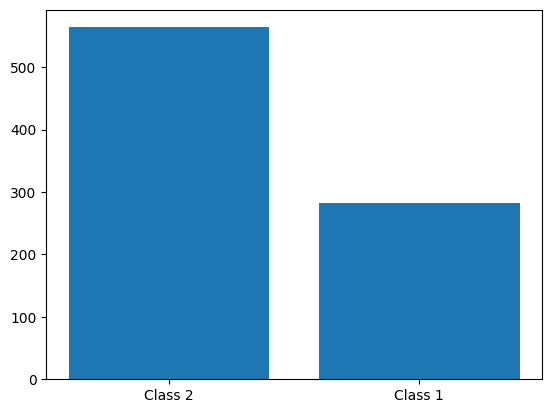

In [56]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.sample()
df.loc[:, "V1":"V3"]
classes = df.loc[:, "Class"].value_counts()
#print(classes, sum(classes))
y_pos = np.arange(len(classes), step=1)
print(classes)
plt.bar(y_pos, classes)
plt.xticks(y_pos, {"Class 1", "Class 2"})

In [57]:
#any(df.isnull())    # Missing values

#df.isnull().sum()
df_test = df_test.fillna(df.mean())
df = df.fillna(df.mean())   # Fill missing values with the mean values
#df.loc[:, "Class"]

Sorted Features


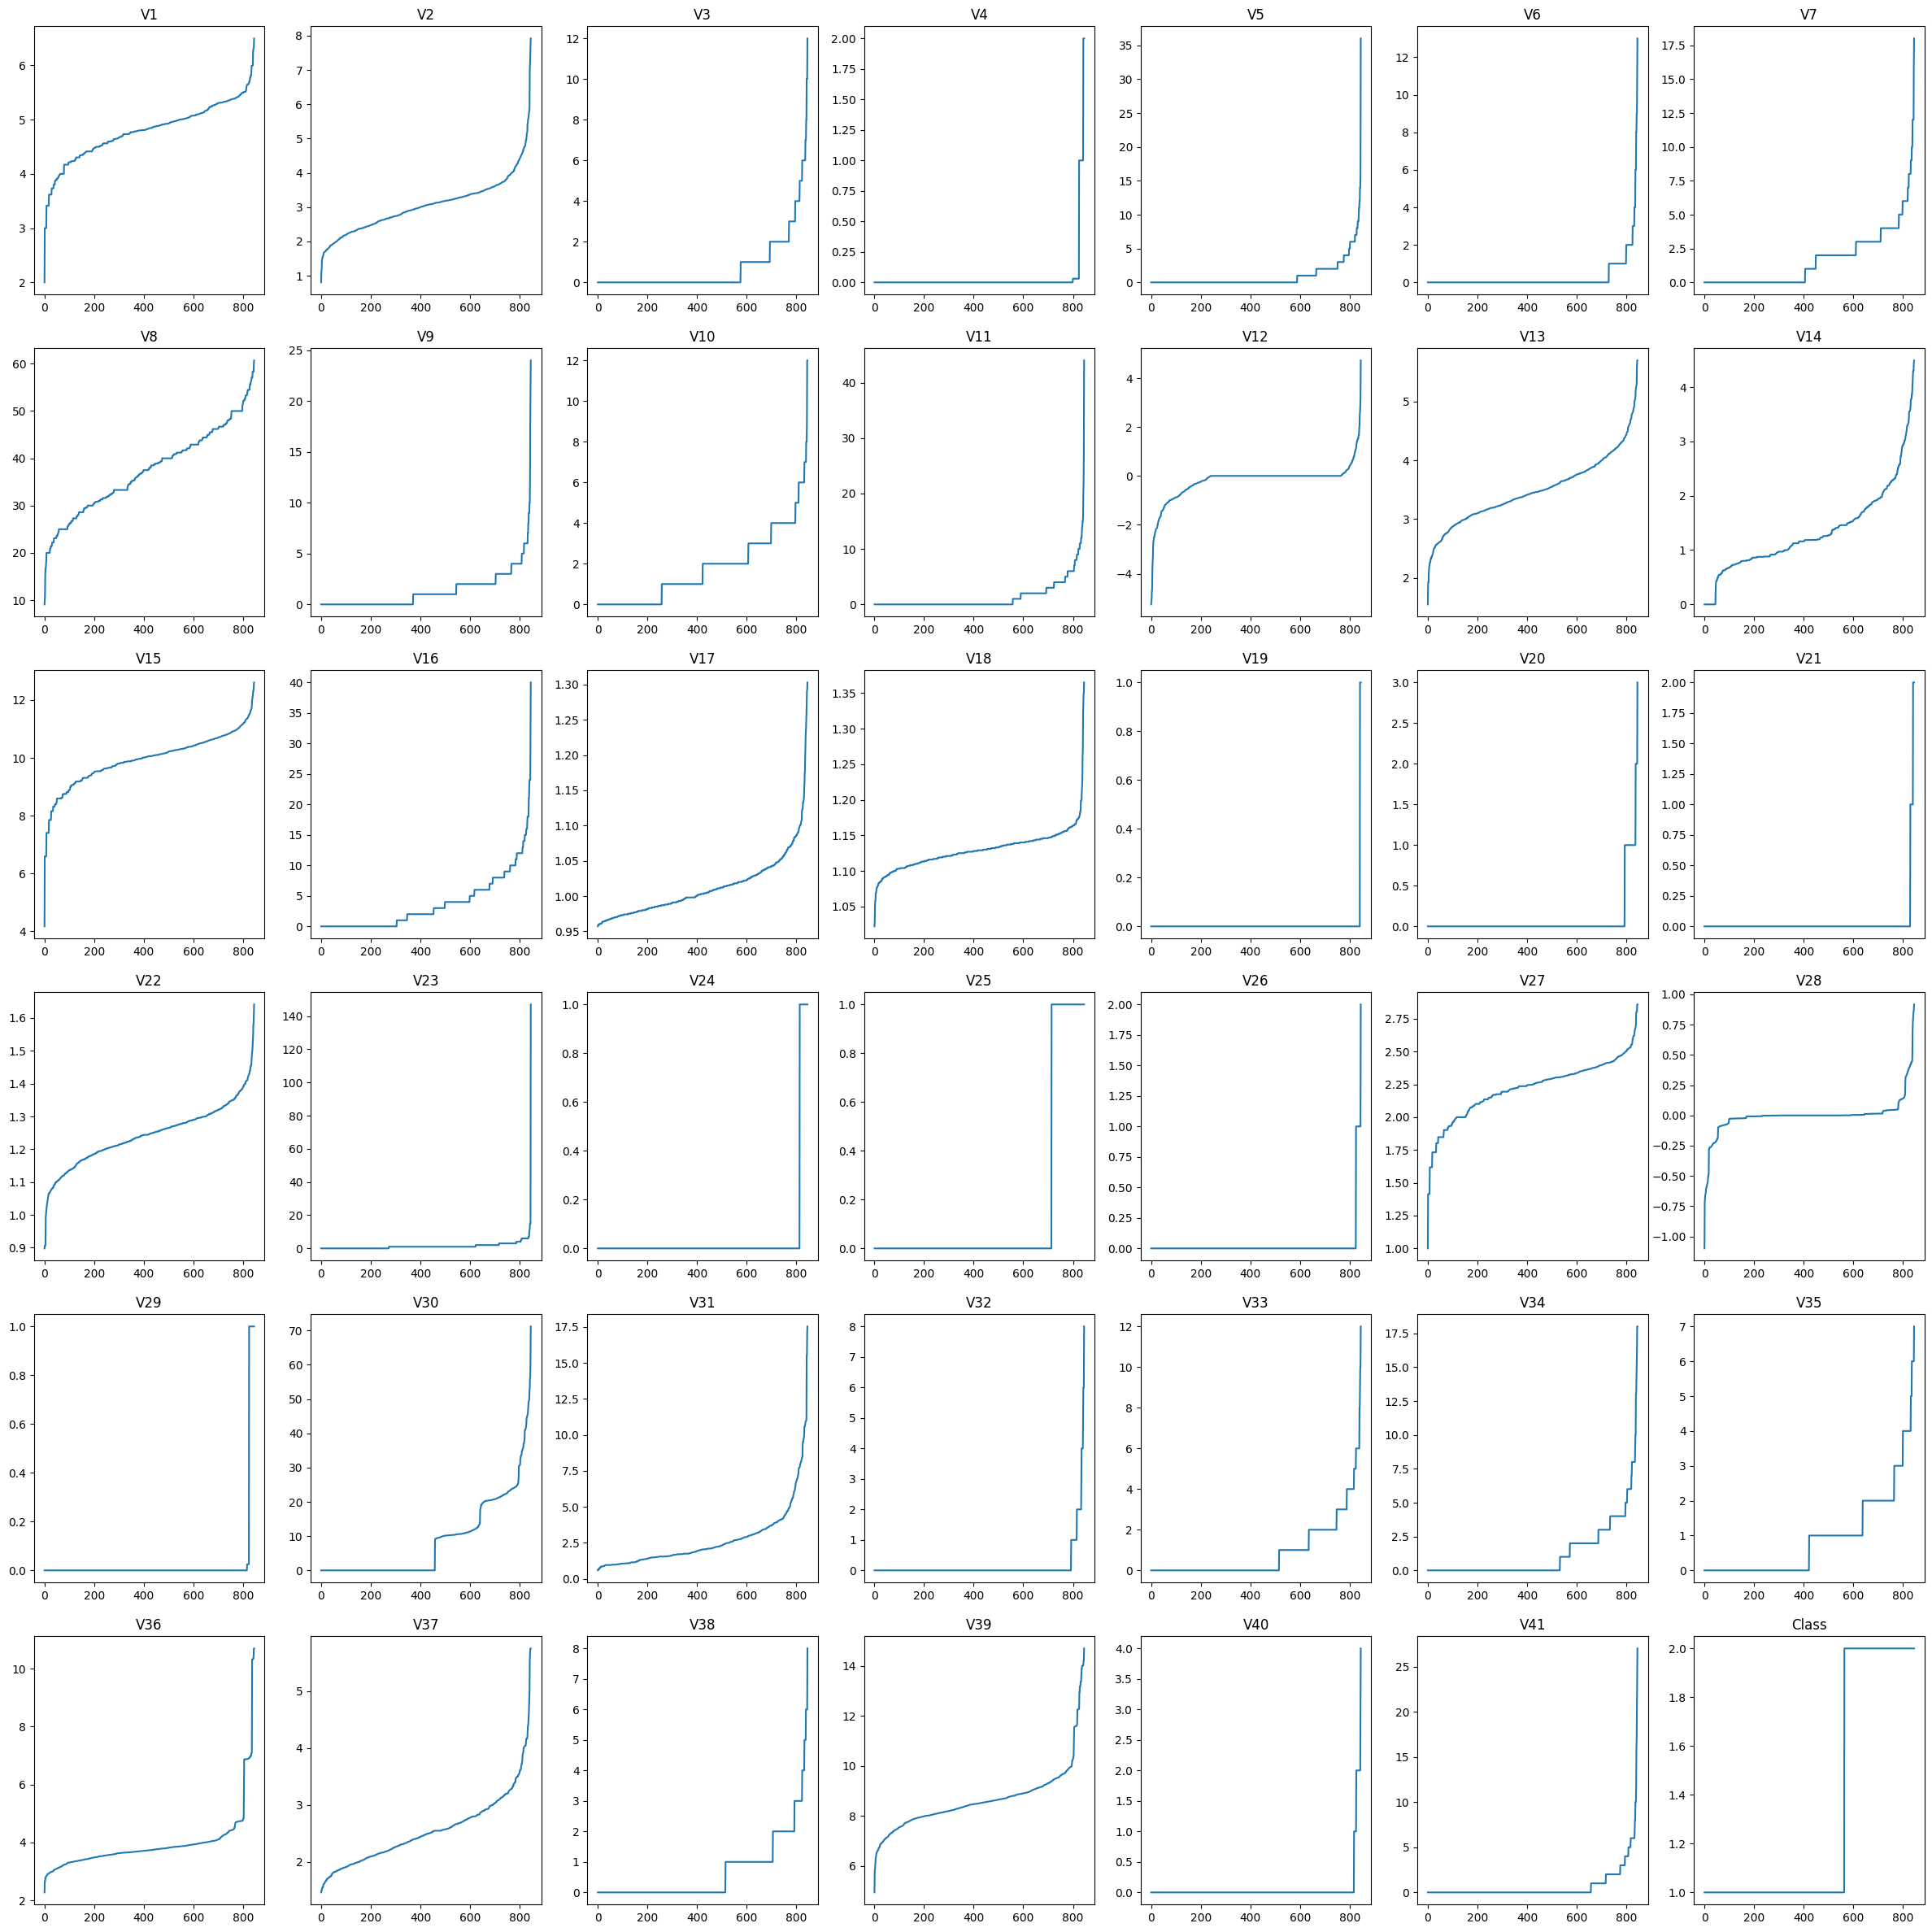

In [58]:
print("Sorted Features")
fig, ax = plt.subplots(6,7, figsize=(30,30))

for x in range(len(df.columns)):
    ax[x//7,x%7].plot(np.sort(df[df.columns[x]]))
    ax[x//7,x%7].set_title(df.columns[x])

In [59]:
colors = ["red" if c == 1 else "blue" for c in df["Class"]]
labels = ["Class1" if c == 1 else "Class 2" for c in df["Class"]]

In [60]:
import plotly.express as px
from sklearn.feature_selection import mutual_info_classif

X = df.drop("Class", axis=1)
y = df["Class"]
information_gain = mutual_info_classif(X, y)
print("Paired features sorted by the information gain")
df_sorted = pd.DataFrame({"feature": X.columns, "info_gain": information_gain}).sort_values("info_gain", ascending=False)
print(df_sorted.head())

# Parallel chart

print("Parallel plot of all the features in the data set")
fig = px.parallel_coordinates(df, color="Class")
fig.show()


Paired features sorted by the information gain
   feature  info_gain
35     V36   0.168035
14     V15   0.141137
0       V1   0.134424
26     V27   0.125166
21     V22   0.115126
Parallel plot of all the features in the data set


/home/sebastijan/.local/lib/python3.8/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



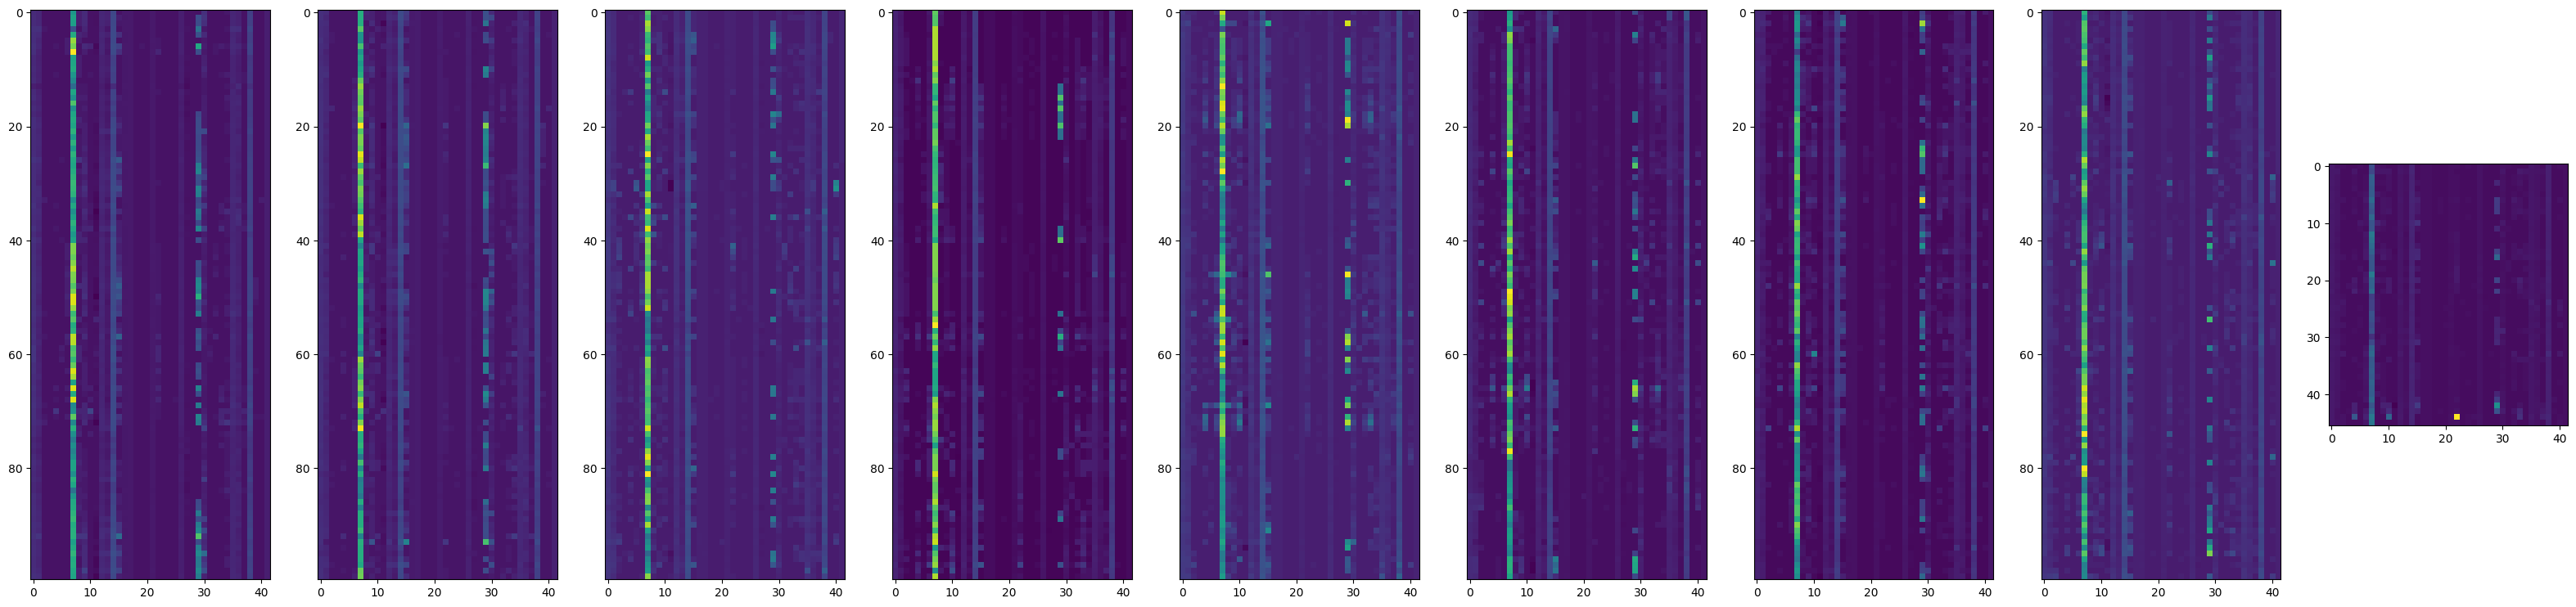

In [61]:
fig, ax = plt.subplots(1,9, figsize=(40,10))
for i in range(9):
    if i == 0:
        ax[i].imshow(df.iloc[:100,:])
    else:
        ax[i].imshow(df.iloc[(i)*100:(i+1)*100, :])

/home/sebastijan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/sebastijan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Text(0.5, 1.0, 'Entire data set reduced to 2 dimensions using t-SNE')

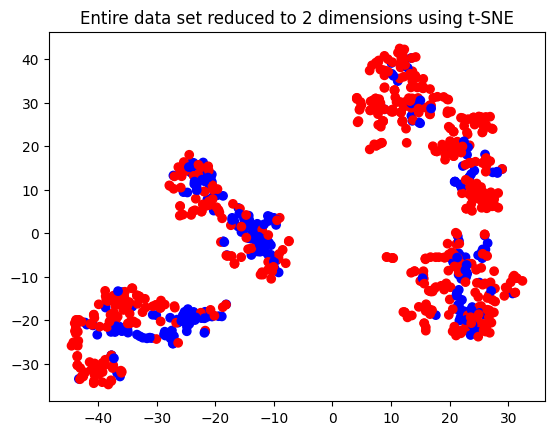

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

x = tsne.fit_transform(df.loc[:, df.columns != "Class"], df["Class"])
plt.scatter(x[:,0], x[:, 1], c=colors)
plt.title("Entire data set reduced to 2 dimensions using t-SNE")

Text(0.5, 0.98, 'Pairs of features, colored by the class')

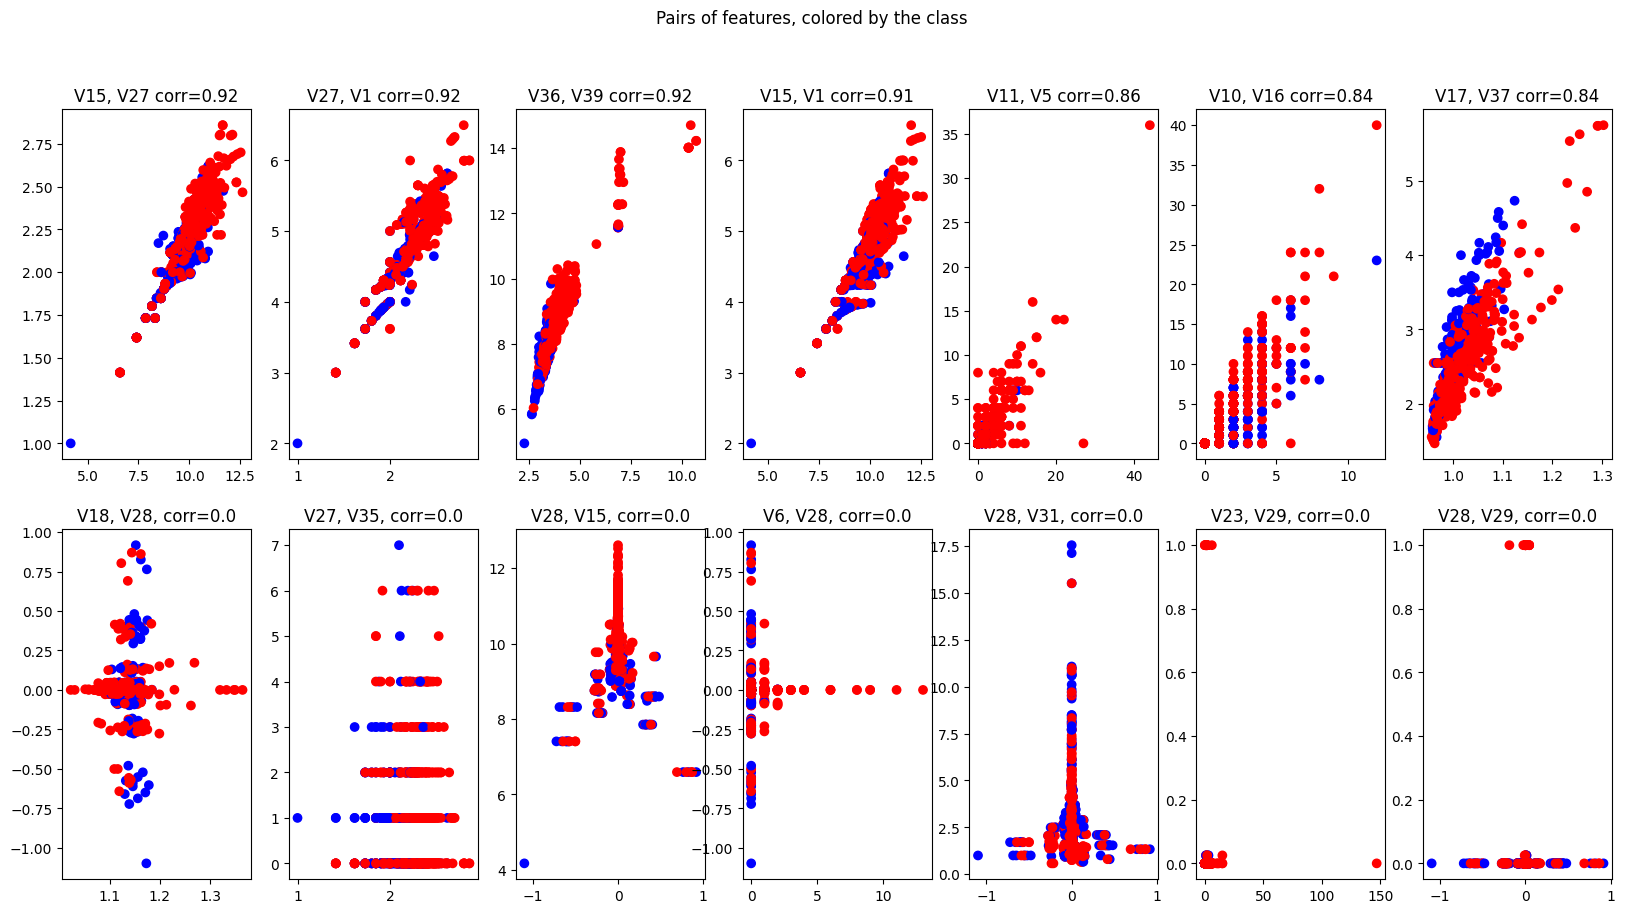

In [63]:
corr = abs(df.corr())   # Only need the magnitude

#corr = np.array(corr)   # Convert to numpy array
#corr = corr[~np.eye(corr.shape[0], dtype=bool)].reshape(corr.shape[0], -1)  # Remove diagonal elements
#corr = pd.DataFrame(corr) # Convert back to dataframe

corr = corr.unstack().sort_values(ascending=False)  # Convert to Series and sort

corr = corr.reset_index()   # Reset labels
corr.columns = ["feature1", "feature2", "corr"] # Rename labels

fig, ax = plt.subplots(2,7, figsize=(20,10))

displayed = set()

n = 0
for i in range(len(corr)):
    if n == 7:
        break
    pair = corr.iloc[i]
    if pair[0] and pair[1] and pair[0] != pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
        ax[0,n].scatter(x=df[pair[0]], y=df[pair[1]], c=colors, label=labels)  # Display pairs with highest correlations
        ax[0,n].set_title(f"{pair[0]}, {pair[1]} corr={round(pair[2], 2)}")
        
        displayed.add((pair[0], pair[1]))
        n += 1

n = 0
for i in range(len(corr)):
    if n >= 7:
        break
    
    pair = corr[::-1].iloc[i]
    if pair[0] and pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
        ax[1,n].scatter(x=df[pair[0]], y=df[pair[1]], c=colors, label=labels)  # Display pairs with lowest correlations
        ax[1,n].set_title(f"{pair[0]}, {pair[1]}, corr={round(pair[2], 2)}")
        
        displayed.add((pair[0], pair[1]))        
        n += 1
        
fig.suptitle("Pairs of features, colored by the class")

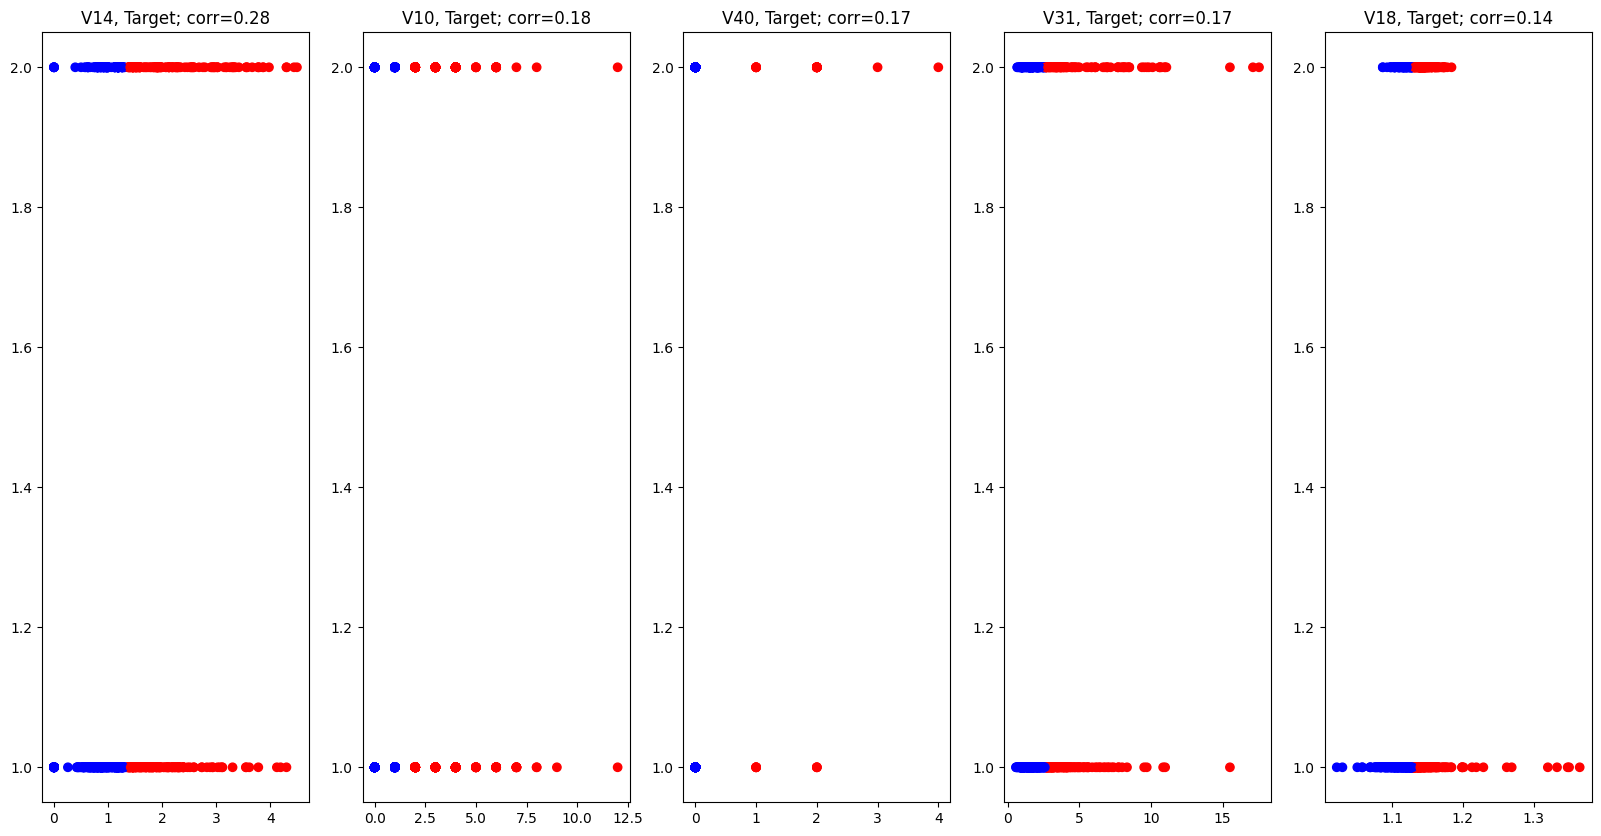

In [64]:
# Get correlation of each feature to the target class and plot the ones with highest correlation
fig, ax = plt.subplots(1,5, figsize=(20,10))

target_corr = df.corr()
pairs = []

for i in range(len(target_corr)-1):
    pairs.append((f"V{i+1}", target_corr.iloc[i,-1]))

pairs = sorted(pairs, key=lambda x: x[1])
pairs = pairs[::-1]

def get_colors(feature: str) -> np.ndarray:
    '''
        Colors the points based on their value compared to the mean
    '''
    mean = np.mean(df[feature])
    target_colors = ["red" if f > mean else "blue" for f in df[feature]]
    return target_colors
    
     

for i in range(5):
    ax[i].scatter(x=df.loc[:,pairs[i][0]], y=df.loc[:,"Class"], label=pairs[i][0], c=get_colors(pairs[i][0]))
    ax[i].set_title(f"{pairs[i][0]}, Target; corr={round(pairs[i][1], 2)}")
        
    

# Modeling

### Majority classifier

In [65]:
class MajorityClassifier:
    '''
        Classifies the class with the majority classifier. Constructor takes in a pandas dataframe
    '''
    
    def __init__(self, df):
        self.df = df
        
    def fit(self):
        return self.df["Class"].mode()[0]
        

In [66]:
mc = MajorityClassifier(df)
mc.fit()

1

### Random classifier

In [67]:
class RandomClassifier:
    '''
        Classifies the class randomly. Constructor takes in a pandas dataframe
    '''
    def __init__(self, df):
        self.df = df
        
    def fit(self):
        return np.random.choice(self.df["Class"].values)

In [68]:
rc = RandomClassifier(df)
rc.fit()

1

### KNN - K Nearest Neighbors Model

In [69]:
# https://scikit-learn.org/stable/modules/neighbors.html
class KNeighbors:
    '''
        K Nearest Neigbors. Constructor takes in the train and test dataframe
    '''
    def __init__(self, train_df, test_df, n_neighbors=5):
        self.train_df = train_df
        self.test_df = test_df
        self.n_neighbors = n_neighbors
        
    def fit(self, n_neighbors=5, weights="uniform", metric="minkowski"):
        # Get train and test data
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
                
        # Get KNN object and fit the data
        clf = neighbors.KNeighborsClassifier(self.n_neighbors, weights=weights, metric=metric)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        return clf, accuracy
    
    def filter_features(self):
        return

In [70]:
knn = KNeighbors(df, df_test, 3)
clf, knn_accuracy = knn.fit(n_neighbors=5)
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

KNN accuracy:  75.598%


KNN prediction plot

Text(0.5, 1.0, 'Diff')

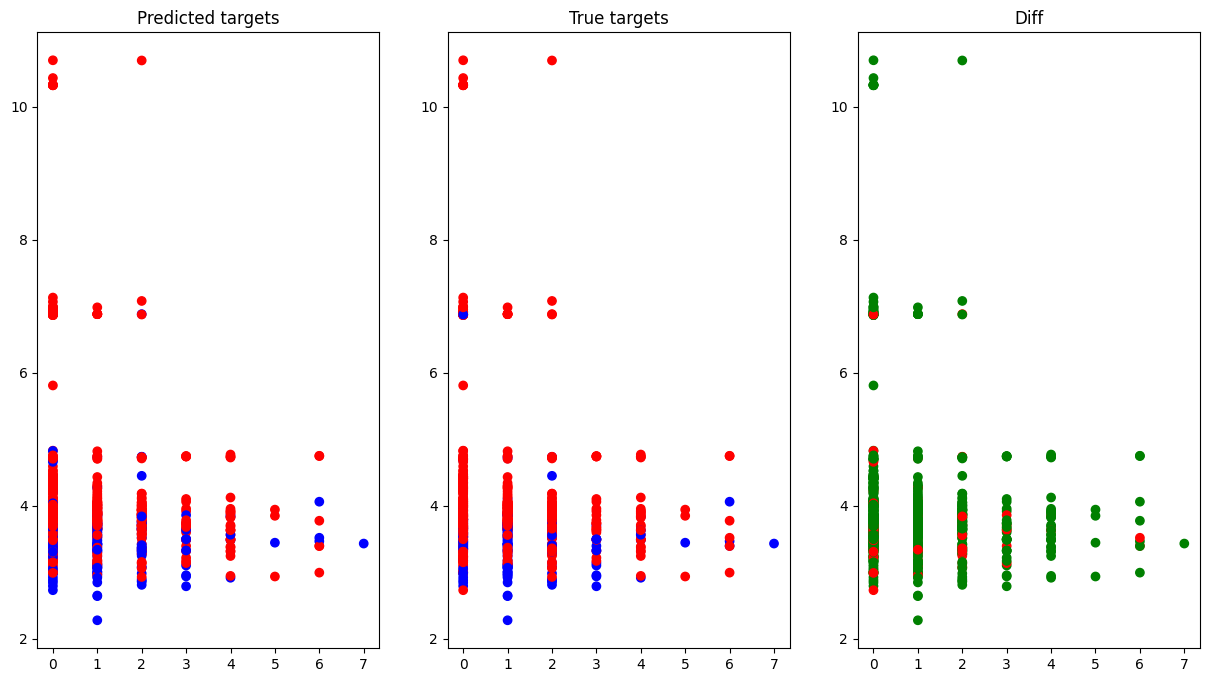

In [71]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])

fig, ax = plt.subplots(1,3, figsize=(15,8))

features = ["V35", "V36"]

predicted_colors = ["red" if target == 1 else "blue" for target in prediction]
diff_colors = ["green" if predicted == target else "red" for target, predicted in zip(df["Class"], prediction)]

ax[0].scatter(x=df[features[0]], y=df[features[1]], c=predicted_colors) 
ax[0].set_title("Predicted targets")

ax[1].scatter(x=df[features[0]], y=df[features[1]], c=colors)
ax[1].set_title("True targets")

ax[2].scatter(x=df[features[0]], y=df[features[1]], c=diff_colors)
ax[2].set_title("Diff")

Points as predicted by KNN and colored by the actual target


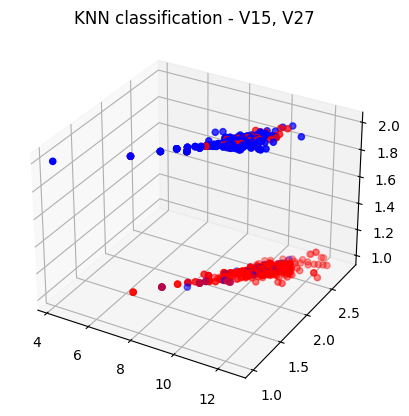

In [72]:
from mpl_toolkits.mplot3d import Axes3D

features = ["V15", "V27", "Class"]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"KNN classification - {features[0]}, {features[1]}")
print("Points as predicted by KNN and colored by the actual target")

### SVM - Support Vector Machine Model

In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# https://scikit-learn.org/stable/modules/svm.html
class SupportVector:
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df
        
    def fit(self, kernel="linear", degree=2, gamma="auto"):
        # Get train and test data
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
        
        
        clf = SVC(kernel=kernel, degree=degree, gamma=gamma)
        clf.fit(X_train, y_train)
        
        accuracy = clf.score(X_test, y_test)
        
        return clf, accuracy

In [74]:
svm = SupportVector(df, df_test)
clf, svm_accuracy = svm.fit(kernel="linear")
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

SVM accuracy: 84.689%


Points as predicted by SVM and colored by the actual target


Text(0.5, 0.5, 'V27')

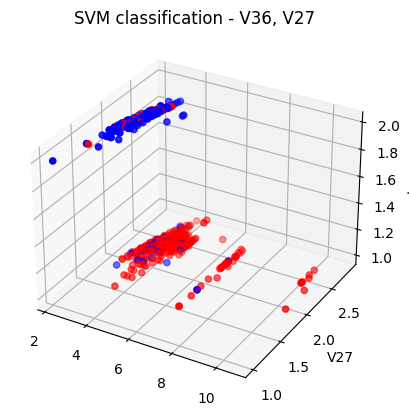

In [75]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])

features = ["V36", "V27", "Class"]

predicted_colors = ["red" if target == 1 else "blue" for target in prediction]
diff_colors = ["green" if predicted == target else "red" for target, predicted in zip(df["Class"], prediction)]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"SVM classification - {features[0]}, {features[1]}")
print("Points as predicted by SVM and colored by the actual target")
ax.set_zlabel("class")
ax.set_ylabel(features[1])

# Plot the seperating hyperplane - TODO
#hplane = clf.decision_function(df.loc[:, df.columns != "Class"])
#w = clf.coef_[0]
#a,b,c = -w[0] / w[1], -w[0] / w[2], -w[0] / w[3]
#
#xx = np.linspace(0, 14)
#yy = np.linspace(0, 14)
#XX, YY = np.meshgrid(xx, yy)
#ZZ = hplane#clf.decision_function()
#ZZ = ZZ.reshape(XX.shape)
#ax.plot_surface(XX, YY, ZZ, alpha=0.5, cmap='RdBu')

### Random forests

In [76]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html    
class RandomForest:
        def __init__(self, train_df, test_df):
            self.train_df = train_df
            self.test_df = test_df
            
        def fit(self, n_estimators=100, criterion="gini", max_depth=None):
            X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
            X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
            
            clf = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
            clf.fit(X_train, y_train)
            
            accuracy = clf.score(X_test, y_test)
            
            return clf, accuracy

In [77]:
rf = RandomForest(df, df_test)
clf, rf_accuracy = rf.fit(n_estimators=200, criterion="log_loss", max_depth=10)

print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

Random Forest Classificator accuracy: 82.3%


In [78]:
test_colors = ["red" if c == 1 else "blue" for c in df_test["Class"]]

(209,)
Points as predicted by RF and colored by the actual target


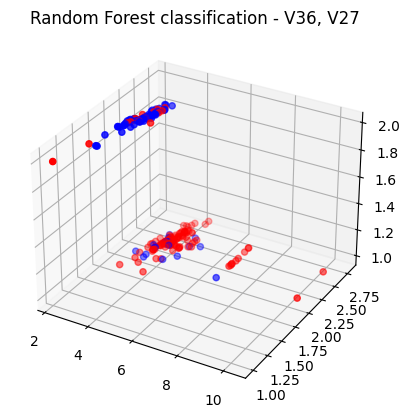

In [79]:
prediction = clf.predict(df_test.loc[:, df_test.columns != "Class"])
print(prediction.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs=df_test[features[0]], ys=df_test[features[1]], zs=prediction, c=test_colors)
ax.set_title(f"Random Forest classification - {features[0]}, {features[1]}")
print("Points as predicted by RF and colored by the actual target")


Text(0.5, 1.0, 'Importance of features returned by the random forest classifier')

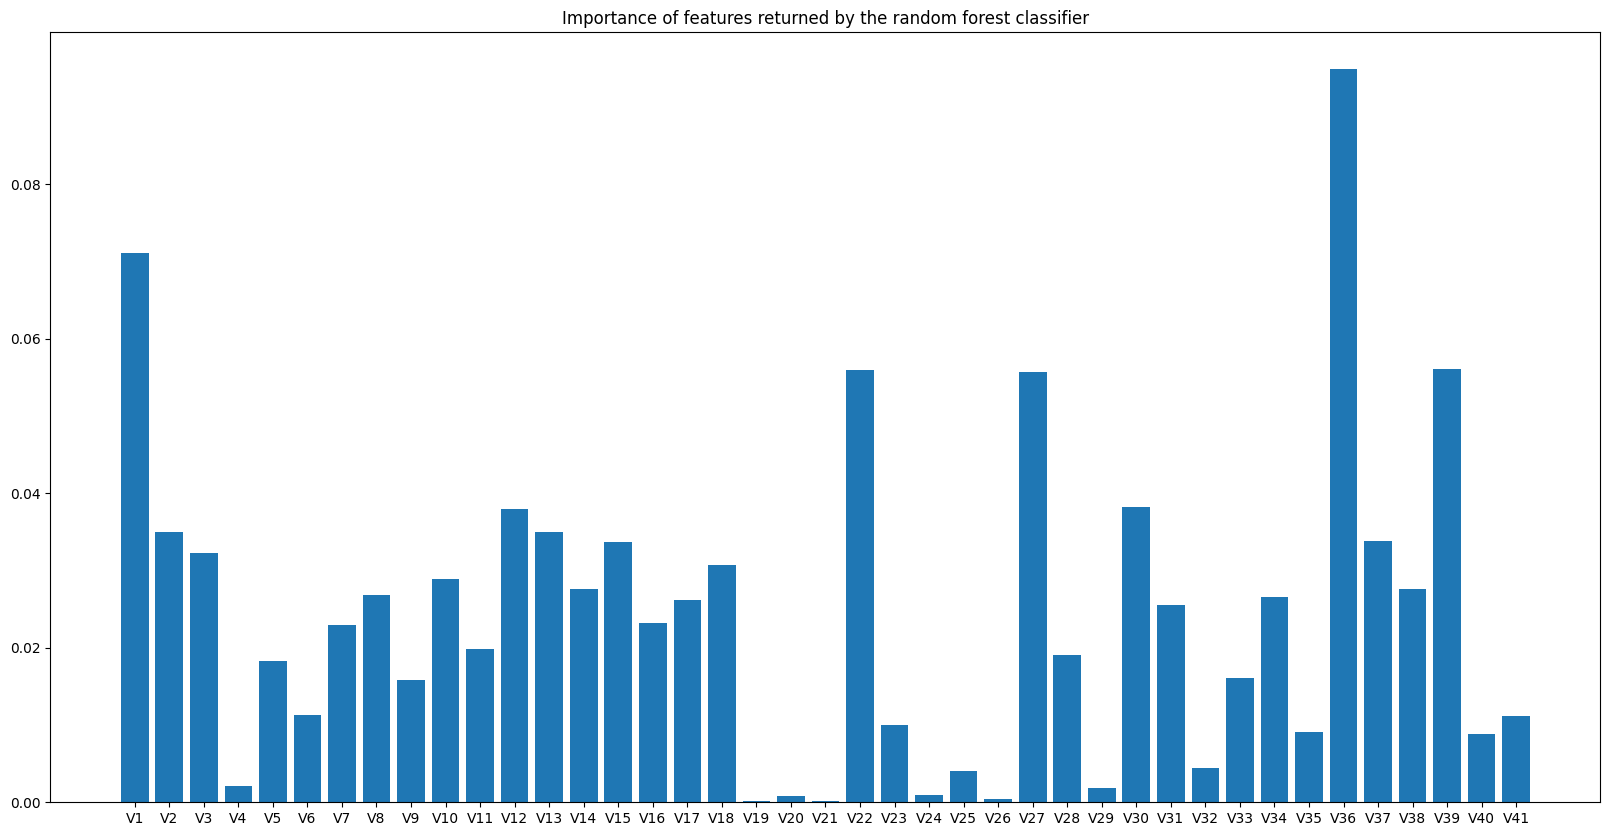

In [80]:
importances = clf.feature_importances_
features = df.columns
plt.figure(figsize=(20,10))
plt.bar(features[:-1], importances)
plt.title("Importance of features returned by the random forest classifier")

### LDA - Linear Discriminant Analysis

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

class LDA:
    def __init__(self, train, test):
        self.train_df = train
        self.test_df = test
        
    def fit(self, solver="svd", shrinkage="auto"):
        # Test train split
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]

        clf = LinearDiscriminantAnalysis(solver=solver)
        clf = clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
       
        return clf, accuracy
       

In [82]:
lda = LDA(df, df_test)
clf, lda_accuracy = lda.fit(solver="lsqr")
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

LDA accuracy 80.86%


Points as predicted by KNN and colored by the actual target


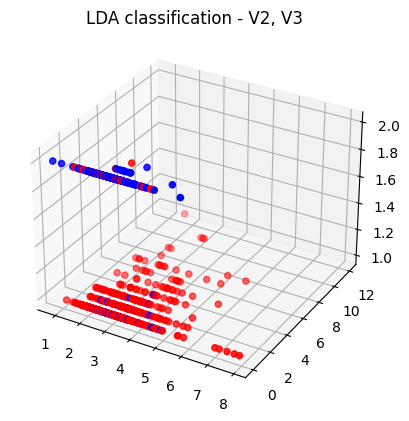

In [83]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])
features = ["V2", "V3"]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"LDA classification - {features[0]}, {features[1]}")
print("Points as predicted by KNN and colored by the actual target")


## Feature selection

In [84]:
from sklearn import feature_selection
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
X, y = df.loc[:, df.columns != "Class"], df["Class"]

In [85]:
df_b = df.loc[:, df.columns != "Class"]
dft_b = df_test.loc[:, df_test.columns != "Class"]
df_norm=(df_b - df_b.mean()) / df_b.std()
dft_norm=(dft_b - dft_b.mean()) / dft_b.std()

colors2 = ["red" if c == 1 else "blue" for c in df_test["Class"]]
col = df.columns

### Removing features with high corelation

In [86]:
def remove_cor(df,df_test, threshold=.85):
    '''
        Returns train and test dataframe without the features with correlation above a given threshold
    '''
    corr = abs(df.corr(method="spearman"))

    corr = corr.unstack().sort_values(ascending=False)

    corr = corr.reset_index()
    corr.columns = ["feature1", "feature2", "corr"]

    displayed = set()
    rem = set()

    for i in range(len(corr)):
        pair = corr.iloc[i]
        if pair[0] and pair[1] and pair[0] != pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
            if pair[2] > threshold:
                displayed.add((pair[0], pair[1]))
                if (pair[0] not in rem and pair[1] not in rem):
                    rem.add(pair[0])

    drop_tr = df.drop(columns=list(rem))
    drop_t = df_test.drop(columns=list(rem))
    return drop_tr, drop_t

In [87]:
print("DataFrame without features with high correlation!")

drop_tr, drop_t = remove_cor(df, df_test)

knn = KNeighbors(drop_tr, drop_t, 9)
clf, knn_accuracy = knn.fit()
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

svm = SupportVector(drop_tr, drop_t)
clf, svm_accuracy = svm.fit()
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

rf_dr = RandomForest(drop_tr, drop_t)
clf, rf_accuracy = rf.fit()
print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

lda = LDA(drop_tr, drop_t)
clf, lda_accuracy = lda.fit()
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

DataFrame without features with high correlation!
KNN accuracy:  79.426%
SVM accuracy: 84.211%
Random Forest Classificator accuracy: 83.73%
LDA accuracy 84.21%


### Removing features with low variance

In [88]:
def remove_low_var(df, df_test, threshold=.16):
    '''
        Removes features with variance below a given threshold
    '''
    selector = feature_selection.VarianceThreshold(threshold)
    selector.fit(df.loc[:, df.columns != "Class"])
    selcol = list(selector.get_support(indices=True))
    selcol.append(len(df.columns)-1)
    df_filtered = df[df.columns[selcol]]
    dft_filtered = df_test.loc[:,df_filtered.columns]
    return df_filtered, dft_filtered

DataFrame without features with high correlation and features with low variance!
KNN accuracy:  78.469%
SVM accuracy: 85.167%
Random Forest Classificator accuracy: 83.25%
       V2  V3  V6  V7    V8  V9  V11    V12    V14    V15  ...  V23     V30  \
3  3.2512   0   0   0  26.7   2    0  0.000  2.585  9.110  ...    0   0.000   
5  3.3944   0   0   0  29.4   2    0 -0.271  2.753  9.528  ...    0  10.348   
6  3.4286   0   0   0  28.6   2    0 -0.275  2.522  9.383  ...    0  10.276   
7  5.0476   1   0   0  11.1   0    0  0.000  0.722  9.657  ...    0  18.375   
8  3.8301   0   0   0  31.6   3    0 -0.039  2.468  9.786  ...    0  11.115   

     V31  V32  V33  V35    V37    V39  V41  Class  
3  4.891    0    0    1  2.417  7.601    0      2  
5  5.588    0    0    0  2.405  8.003    0      2  
6  4.746    0    0    0  2.556  7.904    0      2  
7  0.800    0    0    1  4.583  9.303    0      2  
8  3.889    0    0    0  2.143  7.950    0      2  

[5 rows x 21 columns]
LDA accuracy 82.3%


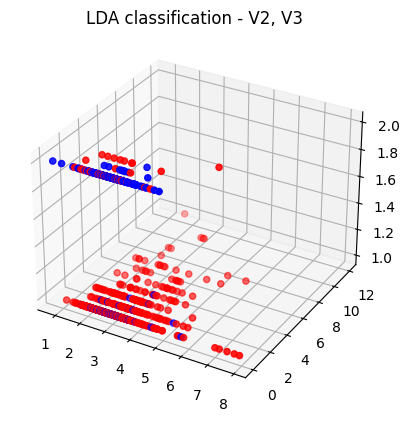

In [89]:
print("DataFrame without features with high correlation and features with low variance!")

df_filtered, dft_filtered = remove_low_var(df, df_test)
df_filtered, dft_filtered = remove_cor(df_filtered, dft_filtered)

knn = KNeighbors(df_filtered, dft_filtered, 8)
clf_knn, knn_accuracy = knn.fit()
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

svm = SupportVector(df_filtered, dft_filtered)
clf_svm, svm_accuracy = svm.fit(kernel="poly")
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

rf_dr = RandomForest(df_filtered, dft_filtered)
clf_rf, rf_accuracy = rf.fit()
print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

lda = LDA(df_filtered, dft_filtered)
clf_lda, lda_accuracy = lda.fit()
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

prediction = clf_lda.predict(df_filtered.loc[:, df_filtered.columns != "Class"])
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df_filtered[features[0]], ys=df_filtered[features[1]], zs=prediction, c=colors)
ax.set_title(f"LDA classification - {features[0]}, {features[1]}")

### Voting Classifier

Accuracy: 0.81 (+/- 0.06) [KNN]
Accuracy: 0.85 (+/- 0.04) [SVM]
Accuracy: 0.84 (+/- 0.05) [RF]
Accuracy: 0.82 (+/- 0.04) [LDA]


Text(0.5, 0.92, 'Vote classification - V2, V3')

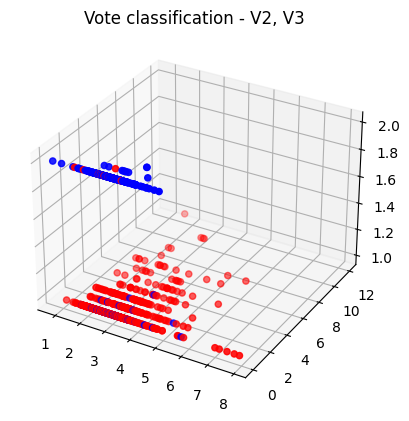

In [110]:
# VOTING CLASSIFIER

eclf = VotingClassifier(estimators=[('knn', clf_knn), ("rf", clf_rf), ("svm", clf_svm), ("lda", clf_lda)], voting="hard")
eclf = eclf.fit(df_filtered.loc[:, df_filtered.columns != "Class"], df_filtered["Class"])
for clf, label in zip([clf_knn, clf_svm, clf_rf, clf_lda], ["KNN", "SVM", "RF", "LDA"]):
    scores = cross_val_score(clf, df_filtered.loc[:, df_filtered.columns != "Class"], df_filtered["Class"], scoring="accuracy")
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    

prediction = eclf.predict(df_filtered.loc[:, df_filtered.columns != "Class"])
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df_filtered[features[0]], ys=df_filtered[features[1]], zs=prediction, c=colors)
ax.set_title(f"Vote classification - {features[0]}, {features[1]}")



### Log-ing some features with exponential distribution

In [91]:
def logtransform(df, df_test):
    lcan = ["V4", "V16", "V20", "V29", "V33"]
    dflog = df.copy()
    dflog[lcan] = dflog[lcan].apply(np.log1p)
    dftlog = df_test.copy()
    dftlog[lcan] = dftlog[lcan].apply(np.log1p)
    return dflog, dftlog

In [92]:
dflog, dftlog = logtransform(df, df_test)

knn = KNeighbors(dflog, dftlog, 9)
clf, knn_accuracy = knn.fit()
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

svm = SupportVector(dflog, dftlog)
clf, svm_accuracy = svm.fit()
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

rf_dr = RandomForest(dflog, dftlog)
clf, rf_accuracy = rf.fit()
print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

lda = LDA(dflog, dftlog)
clf, lda_accuracy = lda.fit()
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

KNN accuracy:  78.947%
SVM accuracy: 85.167%
Random Forest Classificator accuracy: 84.21%
LDA accuracy 82.78%


### PCA transformation

In [93]:
comp = 3

pca = PCA(n_components=comp)
trPCA = pca.fit_transform(df_norm)
trPCA = pd.DataFrame(trPCA, columns = col[:comp])
trPCA.index = df.index
trPCA["Class"] = df["Class"]
tPCA = pca.transform(dft_norm)
tPCA = pd.DataFrame(tPCA, columns = col[:comp])
tPCA.index = df_test.index
tPCA["Class"] = df_test["Class"]

#fig = plt.figure()
#ax = fig.add_subplot(111, projection="3d")
#ax.scatter(xs=trPCA["V1"], ys=trPCA["V2"], zs=trPCA["V3"], c=colors)
#ax.set_title(f"PCA subspace")

knnPCA = KNeighbors(trPCA, tPCA, 9)
clf, knnPCA_accuracy = knnPCA.fit()
print("KNN accuracy: ", str(round(knnPCA_accuracy*100, 3)) + "%")

rfPCA = RandomForest(trPCA, tPCA)
clf, rfPCA_accuracy = rfPCA.fit()
print("Random Forest Classificator accuracy:", str(round(rfPCA_accuracy*100, 3)) + "%")

svmPCA = SupportVector(trPCA, tPCA)
clf, svmPCA_accuracy = svmPCA.fit(kernel="linear", degree=2)
print("SVM accuracy:", str(round(svmPCA_accuracy*100, 3)) + "%")

ldaPCA = LDA(trPCA, tPCA)
clf, ldaPCA_accuracy = ldaPCA.fit()
print("LDA accuracy", str(round(ldaPCA_accuracy*100, 3)) + "%")

KNN accuracy:  80.383%
Random Forest Classificator accuracy: 81.818%
SVM accuracy: 74.641%
LDA accuracy 75.12%


#### Univariate feature selection
##### Select K-Best

In [94]:
kbest = feature_selection.SelectKBest(k=30)
y1 = df["Class"]
df_k_best = kbest.fit_transform(df.loc[:, df.columns != "Class"], df["Class"])
df_k_best = pd.DataFrame(df_k_best)
df_k_best["Class"] = np.array(y1)

y2 = df_test["Class"]
dft_k_best = kbest.fit_transform(df_test.loc[:,df_test.columns != "Class"], df_test["Class"])
dft_k_best = pd.DataFrame(dft_k_best)
dft_k_best["Class"] = np.array(y2)

#df_k_best, dft_k_best = remove_low_var(df, df_test)
#df_k_best, dft_k_best = remove_cor(df_filtered, dft_filtered)

knn = KNeighbors(df_k_best, dft_k_best, 8)
clf_knn, knn_accuracy = knn.fit()
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

svm = SupportVector(df_k_best, dft_k_best)
clf_svm, svm_accuracy = svm.fit(kernel="poly")
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

rf_dr = RandomForest(df_k_best, dft_k_best)
clf_rf, rf_accuracy = rf.fit()
print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

lda = LDA(df_k_best, dft_k_best)
clf_lda, lda_accuracy = lda.fit()
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

KNN accuracy:  64.593%
SVM accuracy: 64.115%
Random Forest Classificator accuracy: 83.73%
LDA accuracy 35.41%


# Evaluation
* 1. K-Fold cross validation - 5-fold 10 times -> 50 sets of data to estimate accuracy
* * 5-fold for each model
* * 10 times with different folds for each model, average results
* 2. Determine best model and report on it

In [95]:
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

kf = RepeatedKFold(n_splits=5, n_repeats=10)  # 5-fold cross validator

# Feature selected data
df_filtered, dft_filtered = remove_low_var(df, df_test)
df_filtered, dft_filtered = remove_cor(df_filtered, dft_filtered)

# train and test sets
train, test, train_select, test_select = df, df_test, df_filtered, dft_filtered

scores = {
    "knn": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "svm": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "rf": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "lda": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "vote": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "majority": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },

    "random": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
}

for train_ix, test_ix in kf.split(train):
    # Split train data into train and test subsets
    train_rows, test_rows = train.iloc[train_ix], train.iloc[test_ix]
    X_train, y_train = train_rows.loc[:, train_rows.columns != "Class"], train_rows["Class"]
    X_test, y_test = test_rows.loc[:, train_rows.columns != "Class"], test_rows["Class"]
    
    # Create models and store the score
    knn = KNeighbors(train_rows, test_rows, 8)
    knn_clf, knn_acc = knn.fit()
    #select_scores["knn"].append(knn_acc)
    
    knn_pred = knn_clf.predict(X_test)
    scores["knn"]["F1"].append(f1_score(y_test, knn_pred))
    scores["knn"]["Precision"].append(precision_score(y_test, knn_pred))
    scores["knn"]["Recall"].append(recall_score(y_test, knn_pred))
    scores["knn"]["AUC"].append(roc_auc_score(y_test, knn_pred))
    

    svm = SupportVector(train_rows, test_rows)
    svm_clf, svm_acc = svm.fit()
    #select_scores["svm"].append(svm_acc)

    svm_pred = svm_clf.predict(X_test)
    scores["svm"]["F1"].append(f1_score(y_test, svm_pred))
    scores["svm"]["Precision"].append(precision_score(y_test, svm_pred))
    scores["svm"]["Recall"].append(recall_score(y_test, svm_pred))
    scores["svm"]["AUC"].append(roc_auc_score(y_test, svm_pred))

    rf = RandomForest(train_rows, test_rows)
    rf_clf, rf_acc = rf.fit()
    #select_scores["rf"].append(rf_
    # 
    rf_pred = rf_clf.predict(X_test)
    scores["rf"]["F1"].append(f1_score(y_test, rf_pred))
    scores["rf"]["Precision"].append(precision_score(y_test, rf_pred))
    scores["rf"]["Recall"].append(recall_score(y_test, rf_pred))
    scores["rf"]["AUC"].append(roc_auc_score(y_test, rf_pred))
    
    lda = LDA(train_rows, test_rows)
    lda_clf, lda_acc = lda.fit()
    #select_scores["lda"].append(lda_acc)
    
    lda_pred = lda_clf.predict(X_test)
    scores["lda"]["F1"].append(f1_score(y_test, lda_pred))
    scores["lda"]["Precision"].append(precision_score(y_test, lda_pred))
    scores["lda"]["Recall"].append(recall_score(y_test, lda_pred))
    scores["lda"]["AUC"].append(roc_auc_score(y_test, lda_pred))
    
    
    eclf = VotingClassifier(estimators=[('knn', knn_clf), ("svm", svm_clf), ("rf", rf_clf), ("lda", lda_clf)])
    eclf = eclf.fit(train_rows.loc[:, train_rows.columns != "Class"], train_rows["Class"])
    
    eclf_pred = eclf.predict(X_test)
    scores["vote"]["F1"].append(f1_score(y_test, eclf_pred))
    scores["vote"]["Precision"].append(precision_score(y_test, eclf_pred))
    scores["vote"]["Recall"].append(recall_score(y_test, eclf_pred))
    scores["vote"]["AUC"].append(roc_auc_score(y_test, eclf_pred))

    maj = MajorityClassifier(train_rows)
    maj_clf = maj.fit()
    maj_pred = np.zeros(len(y_test))+maj_clf

    scores["majority"]["F1"].append(f1_score(y_test, maj_pred))
    scores["majority"]["Precision"].append(precision_score(y_test, maj_pred))
    scores["majority"]["Recall"].append(recall_score(y_test, maj_pred))
    scores["majority"]["AUC"].append(roc_auc_score(y_test, maj_pred))

    rand_pred = np.random.randint(low=1, high=3,size=len(y_test))

    scores["random"]["F1"].append(f1_score(y_test, rand_pred))
    scores["random"]["Precision"].append(precision_score(y_test, rand_pred))
    scores["random"]["Recall"].append(recall_score(y_test, rand_pred))
    scores["random"]["AUC"].append(roc_auc_score(y_test, rand_pred))

    #for clf, label in zip([knn_clf, svm_clf, rf_clf, lda_clf], ["KNN", "SVM", "RF", "LDA"]):
    #    scores = cross_val_score(clf, train_rows.loc[:, df_filtered.columns != "Class"], df_filtered["Class"], scoring="accuracy")


In [96]:
select_scores = {
    "knn": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "svm": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "rf": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "lda": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "vote": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "majority": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
    "random": {
            "F1": [],
            "Precision": [],
            "Recall": [],
            "AUC": []
        },
}

for train_ix, test_ix in kf.split(train_select):
    # Split train data into train and test subsets
    train_rows, test_rows = train.iloc[train_ix], train.iloc[test_ix]
    X_train, y_train = train_rows.loc[:, train_rows.columns != "Class"], train_rows["Class"]
    X_test, y_test = test_rows.loc[:, train_rows.columns != "Class"], test_rows["Class"]
    
    # Create models and store the score
    knn = KNeighbors(train_rows, test_rows, 8)
    knn_clf, knn_acc = knn.fit()
    #select_scores["knn"].append(knn_acc)
    
    knn_pred = knn_clf.predict(X_test)
    select_scores["knn"]["F1"].append(f1_score(y_test, knn_pred))
    select_scores["knn"]["Precision"].append(precision_score(y_test, knn_pred))
    select_scores["knn"]["Recall"].append(recall_score(y_test, knn_pred))
    select_scores["knn"]["AUC"].append(roc_auc_score(y_test, knn_pred))
    

    svm = SupportVector(train_rows, test_rows)
    svm_clf, svm_acc = svm.fit()
    #select_scores["svm"].append(svm_acc)

    svm_pred = svm_clf.predict(X_test)
    select_scores["svm"]["F1"].append(f1_score(y_test, svm_pred))
    select_scores["svm"]["Precision"].append(precision_score(y_test, svm_pred))
    select_scores["svm"]["Recall"].append(recall_score(y_test, svm_pred))
    select_scores["svm"]["AUC"].append(roc_auc_score(y_test, svm_pred))

    rf = RandomForest(train_rows, test_rows)
    rf_clf, rf_acc = rf.fit()
    #select_scores["rf"].append(rf_
    # 
    rf_pred = rf_clf.predict(X_test)
    select_scores["rf"]["F1"].append(f1_score(y_test, rf_pred))
    select_scores["rf"]["Precision"].append(precision_score(y_test, rf_pred))
    select_scores["rf"]["Recall"].append(recall_score(y_test, rf_pred))
    select_scores["rf"]["AUC"].append(roc_auc_score(y_test, rf_pred))
    
    lda = LDA(train_rows, test_rows)
    lda_clf, lda_acc = lda.fit()
    #select_scores["lda"].append(lda_acc)
    
    lda_pred = lda_clf.predict(X_test)
    select_scores["lda"]["F1"].append(f1_score(y_test, lda_pred))
    select_scores["lda"]["Precision"].append(precision_score(y_test, lda_pred))
    select_scores["lda"]["Recall"].append(recall_score(y_test, lda_pred))
    select_scores["lda"]["AUC"].append(roc_auc_score(y_test, lda_pred))
    
    eclf = VotingClassifier(estimators=[('knn', knn_clf), ("svm", svm_clf), ("rf", rf_clf), ("lda", lda_clf)]) #voting="hard")
    eclf = eclf.fit(train_rows.loc[:, train_rows.columns != "Class"], train_rows["Class"])
    
    eclf_pred = eclf.predict(X_test)
    select_scores["vote"]["F1"].append(f1_score(y_test, eclf_pred))
    select_scores["vote"]["Precision"].append(precision_score(y_test, eclf_pred))
    select_scores["vote"]["Recall"].append(recall_score(y_test, eclf_pred))
    select_scores["vote"]["AUC"].append(roc_auc_score(y_test, eclf_pred))
    #acc = eclf.score(test_rows.loc[:, test_rows.columns != "Class"], test_rows["Class"])

    maj = MajorityClassifier(train_rows)
    maj_clf = maj.fit()
    maj_pred = np.zeros(len(y_test))+maj_clf

    select_scores["majority"]["F1"].append(f1_score(y_test, maj_pred))
    select_scores["majority"]["Precision"].append(precision_score(y_test, maj_pred))
    select_scores["majority"]["Recall"].append(recall_score(y_test, maj_pred))
    select_scores["majority"]["AUC"].append(roc_auc_score(y_test, maj_pred))

    rand_pred = np.random.randint(low=1, high=3,size=len(y_test))

    select_scores["random"]["F1"].append(f1_score(y_test, rand_pred))
    select_scores["random"]["Precision"].append(precision_score(y_test, rand_pred))
    select_scores["random"]["Recall"].append(recall_score(y_test, rand_pred))
    select_scores["random"]["AUC"].append(roc_auc_score(y_test, rand_pred))
    #select_scores["vote"].append(acc)

Repeated 5-fold on all features of the training set.
knn 0.868 +/- 0.02
svm 0.903 +/- 0.02
rf 0.906 +/- 0.02
lda 0.893 +/- 0.02
vote 0.902 +/- 0.02
majority 0.799 +/- 0.03
random 0.572 +/- 0.04

Repeated 5-fold on only selected features of the training set (21 features).
knn 0.865 +/- 0.02
svm 0.904 +/- 0.02
rf 0.905 +/- 0.02
lda 0.898 +/- 0.02
vote 0.905 +/- 0.02
majority 0.8 +/- 0.02
random 0.577 +/- 0.04
0.0 0.972794569425214
2


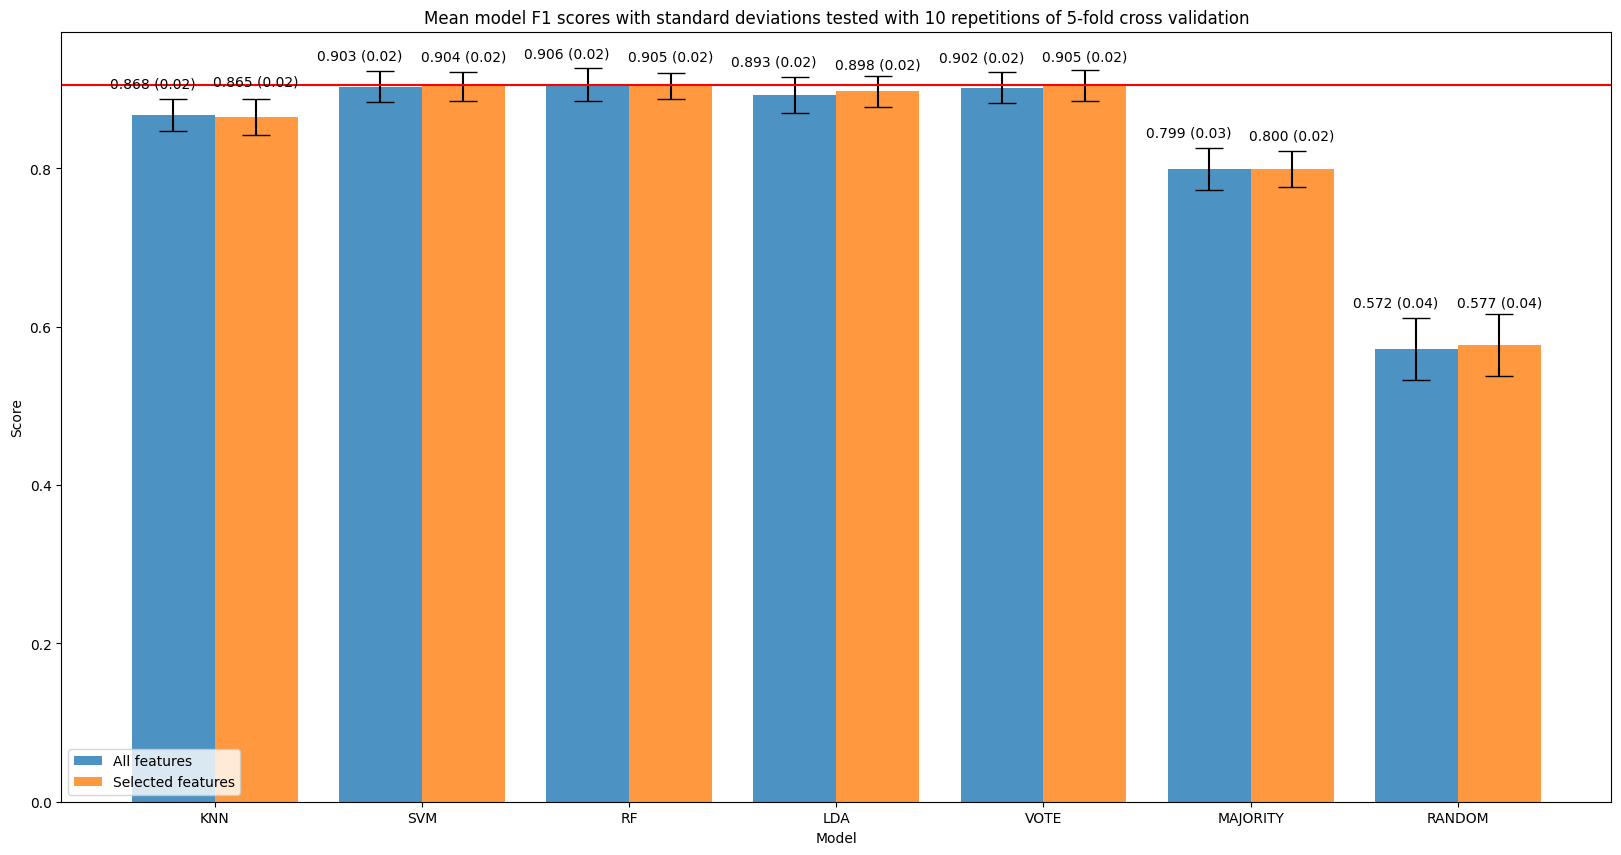

In [104]:
# Get first scores
print("Repeated 5-fold on all features of the training set.")
metrics = ["F1", "Precision", "Recall", "AUC"]
N = 0
models = []
mean_scores = []
std_devs = []
for key in scores:
    print(key, round(np.mean(scores[key][metrics[N]]), 3), "+/-", round(np.std(scores[key][metrics[N]]), 2))
    mean_scores.append(np.mean(scores[key][metrics[N]]))
    models.append(key.upper())
    std_devs.append(np.std(scores[key][metrics[N]]))

# Get second scores
print(f"\nRepeated 5-fold on only selected features of the training set ({train_select.shape[1]} features).")
select_mean_scores = []
select_std_devs = []
for key in select_scores:
    print(key, round(np.mean(select_scores[key][metrics[N]]), 3), "+/-", round(np.std(select_scores[key][metrics[N]]), 2))
    select_mean_scores.append(np.mean(select_scores[key][metrics[N]]))
    select_std_devs.append(np.std(select_scores[key][metrics[N]]))

fig = plt.figure(figsize=(20,10))
plt.title(f"Mean model {metrics[N]} scores with standard deviations tested with 10 repetitions of 5-fold cross validation")
# Get xs
x = np.array([i for i in range(len(models))])

# Plot first scores
plt.bar(x - .2, mean_scores, yerr=std_devs, align="center", width=.4, alpha=.8, ecolor="black", capsize=10, label="All features")
# Plot second scores
plt.bar(x + .2, select_mean_scores, yerr=select_std_devs, align="center", width=.4, alpha=.8, ecolor="black", capsize=10, label="Selected features")
plt.legend(loc="lower left")
plt.xlabel("Model")
plt.ylabel("Score")

plt.xticks(x, models)

# Add scores to the top
for i, bar in enumerate(plt.gca().patches):
    if i == 7: break
    # add the mean score to each bar
    plt.text(bar.get_x() + bar.get_width() / 2 - .1, bar.get_height() + std_devs[i] + .01, f'{mean_scores[i]:.3f} ({std_devs[i]:.2f})', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() + bar.get_width() / 2 , bar.get_height() + select_std_devs[i] + .01, f'{select_mean_scores[i]:.3f} ({select_std_devs[i]:.2f})', ha='center', va='bottom')

y_min, y_max = plt.ylim()
print(y_min, y_max)

hbar_ix = 0
max_y = 0
if max(mean_scores) < max(select_mean_scores):
    max_y = max(select_mean_scores)
    hbar_ix = select_mean_scores.index(max_y)
else:
    max_y = max(mean_scores)
    hbar_ix = mean_scores.index(max_y)
x_pos = x[hbar_ix]
print(x_pos)
plt.axhline(y=max_y, xmin=0, xmax=1, color='red', lw=1.5)



### Testing RF on test set


F1: 0.874
Precision: 0.874
Recall: 0.874
AUC: 0.822


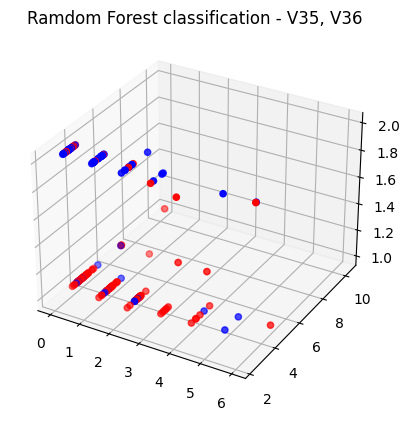

In [123]:
rf = RandomForest(df, df_test)
clf, acc = rf.fit()
prediction = clf.predict(df_test.loc[:, df_test.columns != "Class"])

colors = ["red" if t == 1 else "blue" for t in df_test["Class"]]
features = ["V35", "V36"]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df_test[features[0]], ys=df_test[features[1]], zs=prediction, c=colors)
ax.set_title(f"Ramdom Forest classification - {features[0]}, {features[1]}")


print("F1:", round(f1_score(df_test["Class"], prediction), 3))
print("Precision:", round(precision_score(df_test["Class"], prediction), 3))
print("Recall:", round(recall_score(df_test["Class"], prediction), 3))
print("AUC:", round(roc_auc_score(df_test["Class"], prediction), 3))


['V36' 'V1' 'V39' 'V22' 'V27' 'V12' 'V13' 'V15' 'V30' 'V2' 'V14' 'V37'
 'V18' 'V10' 'V38' 'V31' 'V8' 'V17' 'V16' 'V34' 'V28' 'V3' 'V5' 'V11' 'V9'
 'V33' 'V40' 'V7' 'V41' 'V23' 'V6' 'V35' 'V32' 'V4' 'V25' 'V20' 'V29'
 'V26' 'V24' 'V21' 'V19']


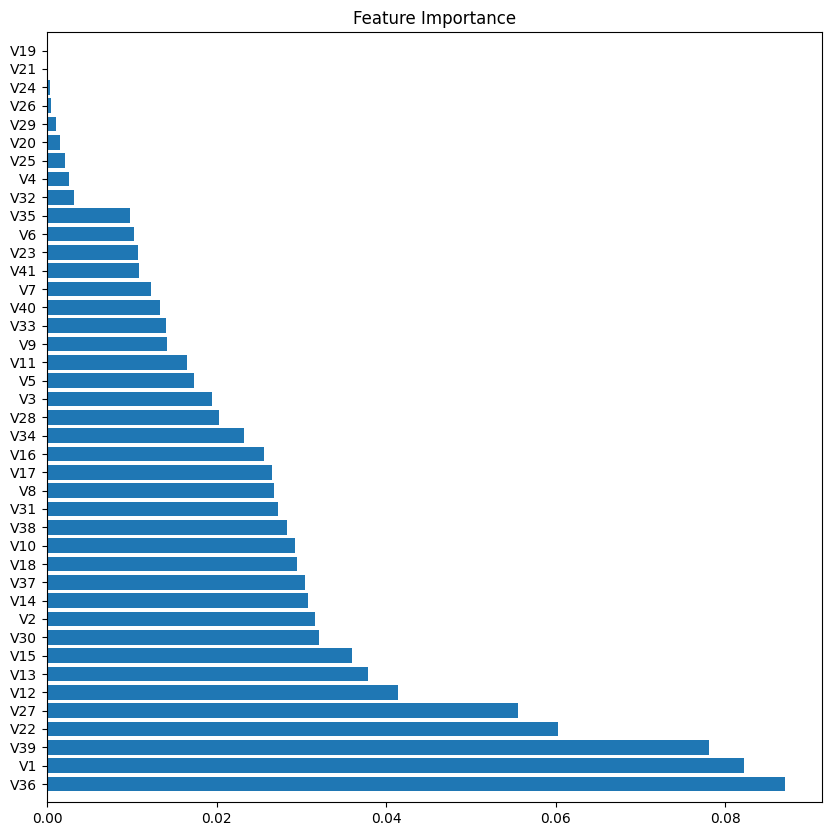

In [129]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = np.array([f"V{i}" for i in range(1,42)])
print(feature_names[indices])

plt.figure(figsize=(10,10))
plt.title("Feature Importance")
plt.barh(range(df.shape[1] -1), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), feature_names[indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()

[Text(0.4880952380952381, 0.9, 'V12 <= -0.007\ngini = 0.442\nsamples = 534\nvalue = [567, 279]\nclass = Deagradable'),
 Text(0.23809523809523808, 0.7, 'V15 <= 10.02\ngini = 0.484\nsamples = 148\nvalue = [98, 140]\nclass = Undegradable'),
 Text(0.09523809523809523, 0.5, 'V10 <= 0.5\ngini = 0.209\nsamples = 55\nvalue = [11, 82]\nclass = Undegradable'),
 Text(0.047619047619047616, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [4, 0]\nclass = Deagradable'),
 Text(0.14285714285714285, 0.3, 'V31 <= 0.953\ngini = 0.145\nsamples = 52\nvalue = [7, 82]\nclass = Undegradable'),
 Text(0.09523809523809523, 0.1, '\n  (...)  \n'),
 Text(0.19047619047619047, 0.1, '\n  (...)  \n'),
 Text(0.38095238095238093, 0.5, 'V5 <= 1.5\ngini = 0.48\nsamples = 93\nvalue = [87, 58]\nclass = Deagradable'),
 Text(0.3333333333333333, 0.3, 'V1 <= 5.074\ngini = 0.497\nsamples = 69\nvalue = [50, 58]\nclass = Undegradable'),
 Text(0.2857142857142857, 0.1, '\n  (...)  \n'),
 Text(0.38095238095238093, 0.1, '\n  (...)  \n'),
 Text(0

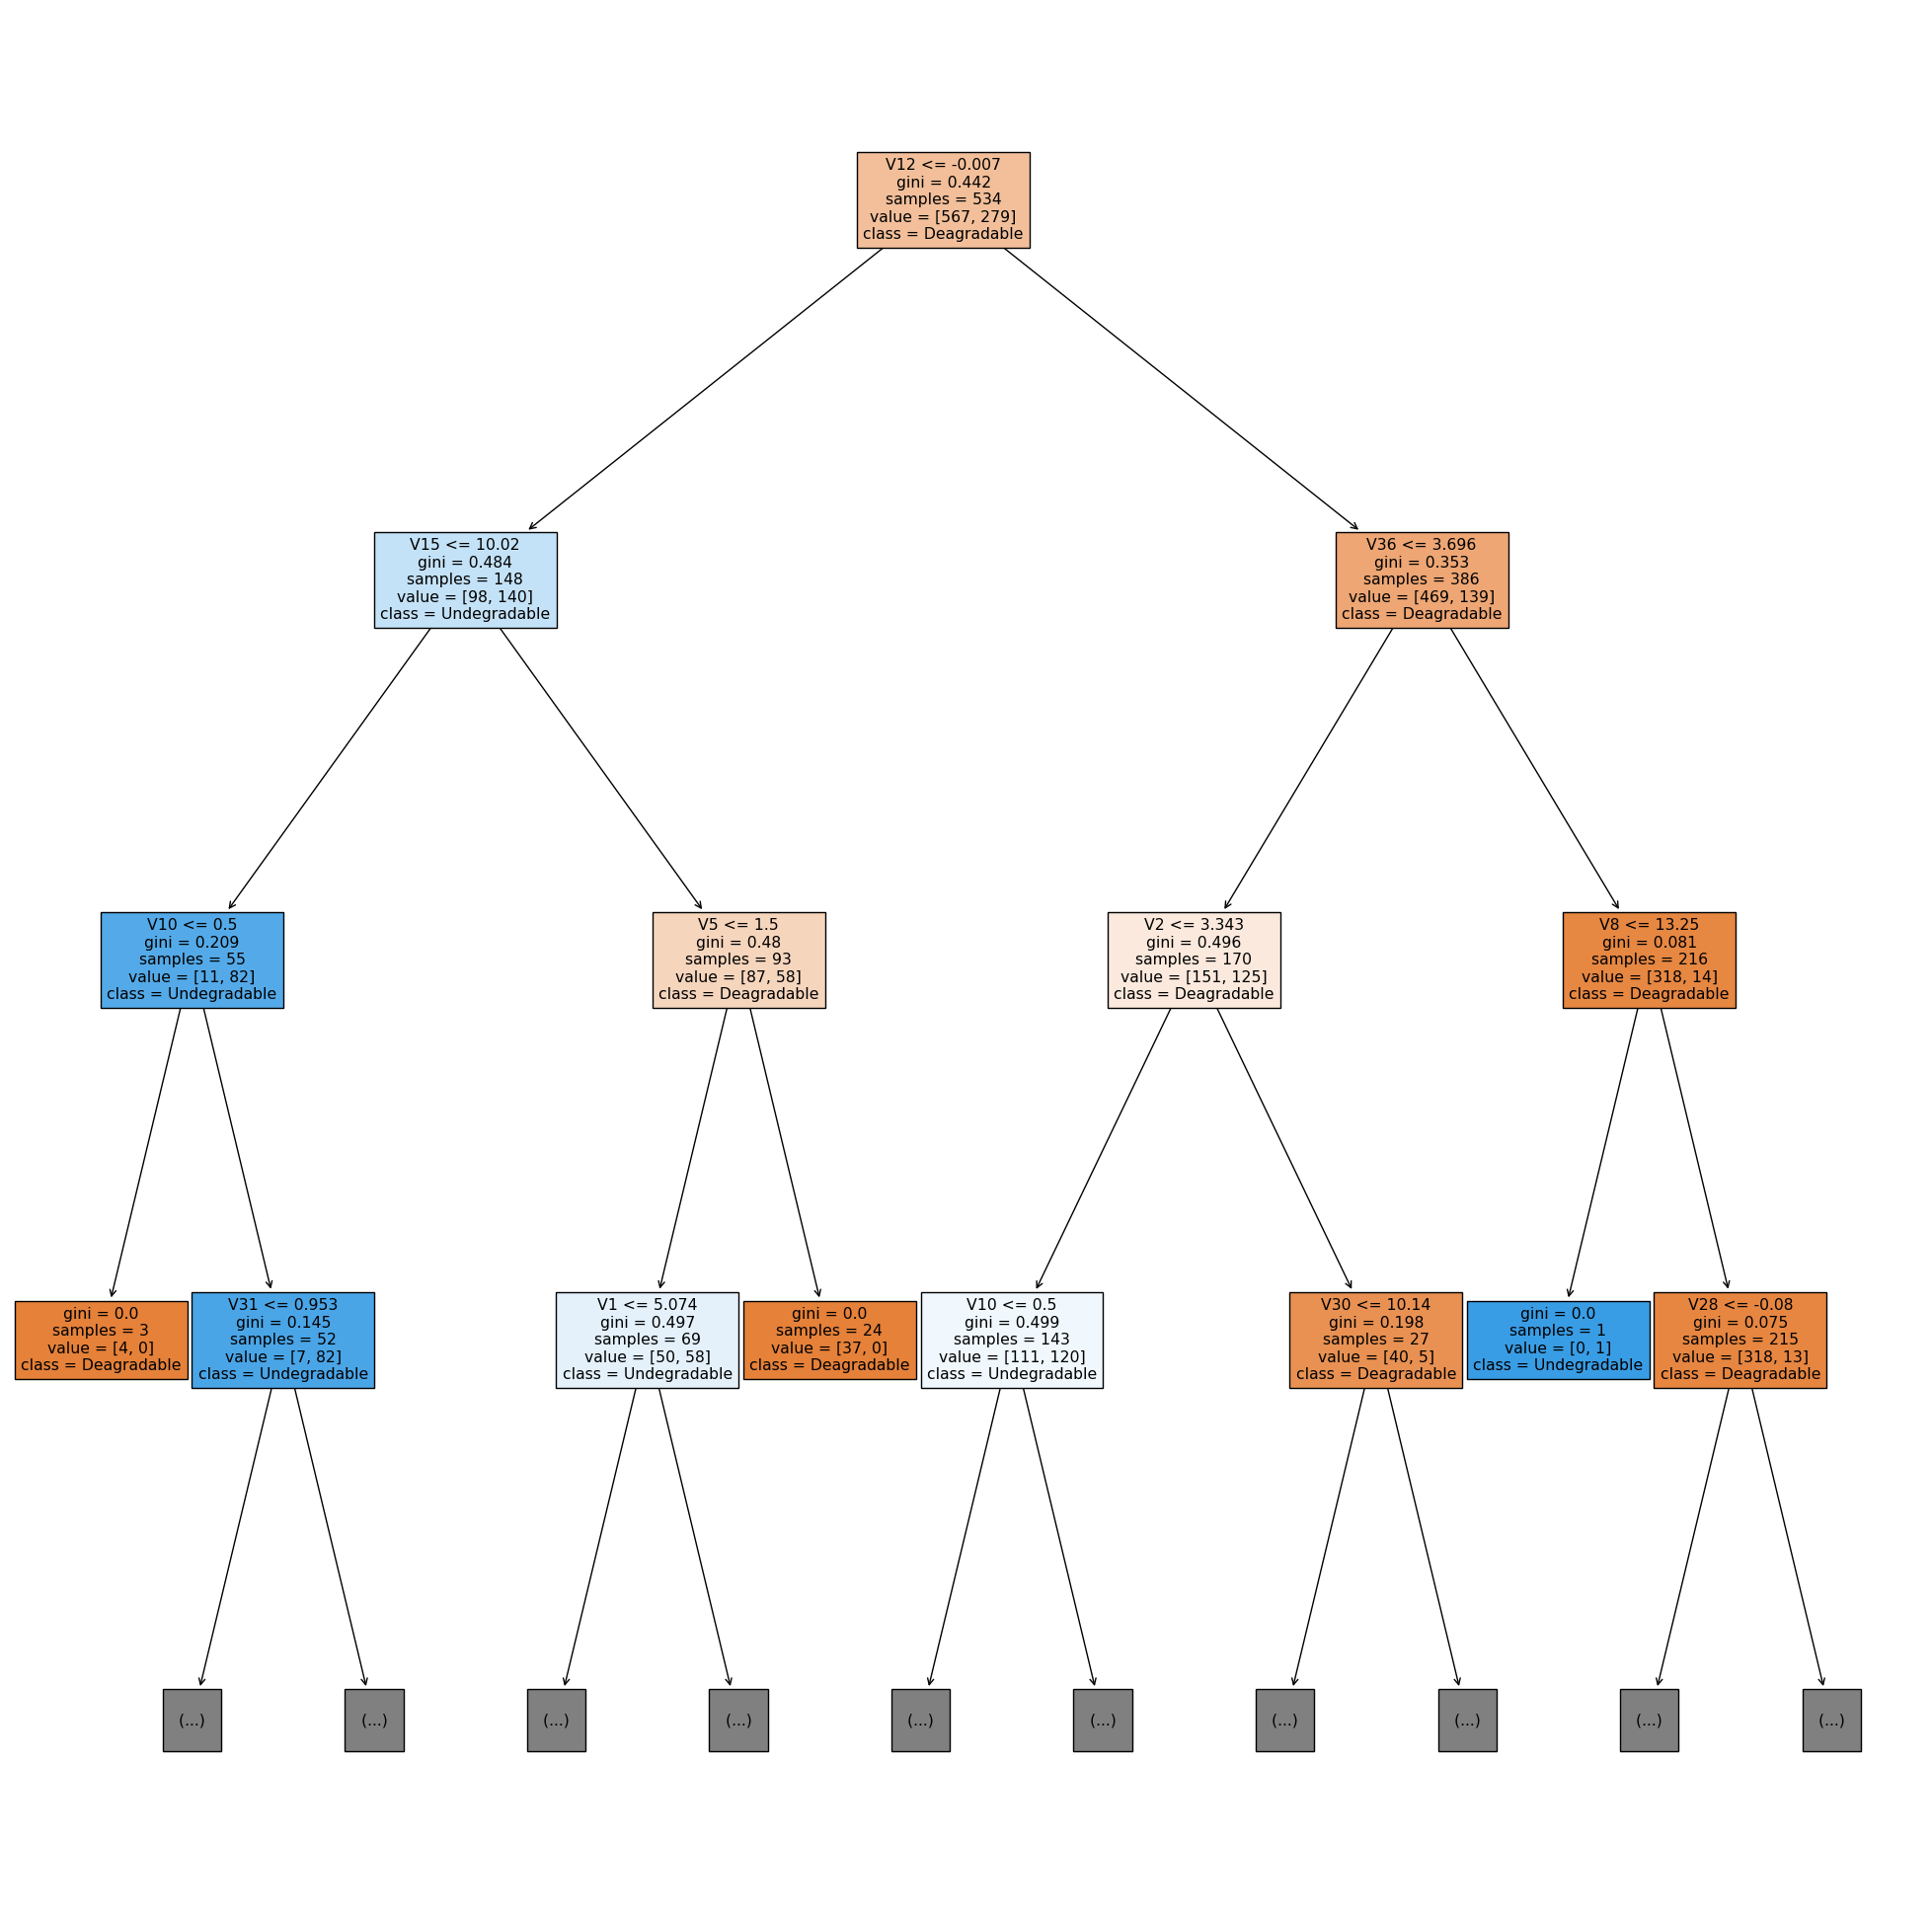

In [135]:
from sklearn.tree import plot_tree

# Plot a tree from a forest
tree = clf.estimators_[0]

plt.figure(figsize=(25,25))
plot_tree(tree, feature_names=feature_names, class_names=["Deagradable", "Undegradable"], filled=True, max_depth=3)